# FMD Scorecard KPIs
This notebook has a few objectives. 

- Come as close as we can to replicating the results reported in previous years. This lets us know that we are all looking at the same data and seeing the same thing
- Show the results we'll get with modified results 

Note that in the past, the Department of General Services has used a multi-phase process to compute KPIs, including SQL Queries and Excel formulas. No one person could see the entire process, beginning with the data in the database (the input) and ending with reported KPI. 

Part of the intention of this notebook is to build _transparency_ and _reproducibility_ by capturing the entire end-to-end process in one place.

## Setup

### Import packages

In [1]:
# workhorse modules
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import re
from pathlib import Path
# import datadotworld as dw
import pyodbc  # for accessing the database directly
import seaborn as sns

# local utility functions
from utils import *
from private.config import config

### Set pandas options
This makes Pandas print all rows and columns to the output when requested.

In [2]:
set_pd_params()

pd.options.mode.chained_assignment = None  # default='warn'

### Import the data from Archibus database
Data is a copy of Archibus's `wrhwr` table. To see the exact query used to generate the input data, see `/sql/input_for_FMD_KPIs.sql`.

In [3]:
query_path = Path.cwd() / "sql" / "input_for_FMD_KPIs.sql"
kpis_raw = get_kpi_data(config, query_path)

print(f"The KPIs raw dataframe has {kpis_raw.shape[0]:,} rows.")
kpis_raw.sample(3, random_state=444)

The KPIs raw dataframe has 104,420 rows.


,wr_id,date_requested,time_requested,date_completed,time_completed,date_closed,pmp_id,bl_id,cost_total,cost_labor,cost_parts,problem_type,requestor,supervisor,po_number,invoice_number,release_number,name,pmp_id,status
65500,94565,2017-10-06,1899-12-30 09:23:35,2017-10-11,1899-12-30 05:25:35,2017-10-12 06:48:23.870,None,B00167,400.20,400.2,0.0,PLUMBING-SINK,SANDRA.DOWNS,JOHN.HAMMOCK,None,None,None,Parking Authority Offices,None,Clo
45398,71083,2016-08-08,1899-12-30 11:24:32,2016-08-08,1899-12-30 14:12:40,2016-08-29 12:37:35.927,ELEVATOR TEST,B00056,0.00,0.0,0.0,PREVENTIVE MAINT,JIMMY.HOLTHAUS,JIMMY.HOLTHAUS,None,None,None,City Hall,ELEVATOR TEST,Clo
57233,86388,2017-04-11,1899-12-30 08:28:41,2017-04-21,1899-12-30 14:39:08,2017-06-13 06:50:03.220,None,B00020,859.74,0.0,0.0,ELEC/OTHER,JIM.FISHER,JIM.FISHER,522751,55764,240,Baltimore City Police Headquarters,None,Clo


## Data cleaning

### Basic cleaning
- removes white spaces in strings to facilitate matching, 
- drops rows with no problem type, 
- renames a few columns

In [4]:
# apply the tidy up function
wr_tidy = tidy_up_wr(kpis_raw)

print(f"The tidied work orders dataframe has {wr_tidy.shape[0]:,} rows.")

The tidied work orders dataframe has 104,030 rows.


### Remove duplicate work orders
Removes rows where technician says WR is a duplicate in the description, and the status is "Canceled", "Closed", or "Rejected". Let's hold off on this step while replicating the traditional KPI.

In [5]:
# This copies the previous step instead of applying deduplication.
wr_deduped = wr_tidy.copy()

# wr_deduped = drop_dupes(wr_tidy)
# print(f"The deduped work orders dataframe has {wr_deduped.shape[0]:,} rows.")
# print(
#     f"Removing duplicates has cut {wr_tidy.shape[0] - wr_deduped.shape[0]:,} rows from the work orders dataframe."
# )

### Combine date and time columns to get timestamps
This takes the date from a date column and the time from a time column and combines them into a single timestamp.

This transformation allows us to know the time to completion with greater precision. 

In [6]:
# glue the date and time for request
wr_dt = glue_date_time(wr_deduped, "date_requested", "time_requested", "requested_dt")

# glue the date and time for completion
wr_dt = glue_date_time(wr_dt, "date_completed", "time_completed", "completed_dt")

# convert "date closed_order" to date time (this column has no time information)
wr_dt["date_closed"] = wr_dt["date_closed"].astype("datetime64")

### Examine the cleaned data

In [7]:
wr_dt[
    ["wr_id", "problem_type", "requested_dt", "completed_dt", "date_closed", "status",]
].sample(3, random_state=451)

,wr_id,problem_type,requested_dt,completed_dt,date_closed,status
101004,134234,HVAC,2020-07-06 08:50:33,NaT,NaT,HC
47619,74818,PLUMB/LEAK,2016-09-14 12:03:31,2016-09-14 12:04:14,2016-09-14 13:43:46.763,Clo
2458,2504,PAINT,2013-12-07 09:54:33,2013-12-07 10:07:32,2013-12-07 00:00:00.000,Clo


## Data preparation

### Include days to completion

In [8]:
wr_durations = compute_days_to_completion(wr_dt)

In [9]:
wr_durations[
    [
        "wr_id",
        "problem_type",
        "requested_dt",
        "completed_dt",
        "date_closed",
        "days_to_completion",
        "status",
    ]
].sample(3, random_state=446)

,wr_id,problem_type,requested_dt,completed_dt,date_closed,days_to_completion,status
requested_dt,,,,,,,
2017-08-16 15:45:11,92404,ELEC/GENERAL,2017-08-16 15:45:11,2017-09-11 08:46:51,2017-10-05 07:58:07.770,25.71,Clo
2015-05-13 13:37:40,31728,DOOR,2015-05-13 13:37:40,2015-05-22 08:23:45,2015-06-01 00:00:00.000,8.78,Clo
2018-01-08 07:24:52,98458,OTHER,2018-01-08 07:24:52,2018-01-08 07:27:10,2018-01-11 11:42:52.580,0.00,Clo


### Decision point: fiscal year
Note that the function `entirely_within_fiscal_year()` keeps only those rows where the work order was requested and closed in the same fiscal year. __Other rows that straddle two fiscal years are dropped__.

For comparison, I've included the function `add_fiscal_year()`, which derives the fiscal year from the request date or from the completion date — and drops no rows.

In [10]:
# this is the traditional way
wr_fy = entirely_within_fiscal_year(wr_durations)

# this is a new way
# wr_fy = add_fiscal_year(wr_durations)

In [11]:
dropped_row_count = len(wr_durations) - len(wr_fy)
percent_rows_dropped = round(dropped_row_count / len(wr_durations) * 100, 2)

print(
    f"Limiting analysis to work orders entirely within one FY drops {dropped_row_count:,} rows from the data."
)
print(f"The dropped rows account for {percent_rows_dropped:,}% of the data.")
print(f"The prepared dataset contains {len(wr_fy):,} rows.")

Limiting analysis to work orders entirely within one FY drops 18,161 rows from the data.
The dropped rows account for 17.46% of the data.
The prepared dataset contains 85,869 rows.


In [12]:
wr_fy[
    [
        "wr_id",
        "problem_type",
        "days_to_completion",
        "requested_dt",
        "completed_dt",
        "fiscal_year",
    ]
].sample(3, random_state=444)

,wr_id,problem_type,days_to_completion,requested_dt,completed_dt,fiscal_year
requested_dt,,,,,,
2015-02-24 10:55:48,24685,SERV/CUSTODIAL,0.00,2015-02-24 10:55:48,2015-02-24 10:56:38,2015
2016-12-12 14:22:39,79848,HVAC,32.01,2016-12-12 14:22:39,2017-01-13 14:33:01,2017
2017-06-20 08:54:05,89616,DOOR,9.98,2017-06-20 08:54:05,2017-06-30 08:25:30,2017


## KPI 1: % PMs completed on time 
The goal here is to filter the data down to preventive maintenance only, and then show how many are completed before a given benchmark.

### Filter to PM only, and for relevant fiscal years only

In [13]:
PM_list = [
    "HVAC|PM",
    "BUILDING|PM",
    "PREVENTIVE MAINT",
    "FUEL INSPECTION",
    "BUILDING INTERIOR INSPECTION",
    "INSPECTION",
    "FUEL INSPECTION",
]

cond_fy = wr_fy["fiscal_year"].isin(range(2016, 2021))
cond_pm = wr_fy["problem_type"].isin(PM_list)

wr_filtered = wr_fy[cond_fy & cond_pm]

print(f"The filtered work orders dataframe has {wr_filtered.shape[0]:,} rows.")

The filtered work orders dataframe has 6,153 rows.


#### Compute the benchmark and add 'is_on_time' column

In [14]:
def compute_is_on_time(df, benchmark):
    df = df.copy()
    df["is_on_time"] = df["days_to_completion"] <= benchmark
    return df


wr_on_time = compute_is_on_time(wr_filtered, 26)

#### Group by fiscal year and get % on time

In [32]:
def compute_kpi_table(df, label_for_totals):
    df = df.copy()
    table_df = df.groupby("fiscal_year")[["is_on_time"]].agg(["mean", "count"])
    table_df.columns = table_df.columns.droplevel(0)
    # table_df["mean"] = pm_compliance["mean"].round(2)
    table_df["mean"] = table_df["mean"].apply(lambda x: round(x * 100, 2))
    table_df = table_df.rename(
        columns={"mean": "percent_on_time", "count": label_for_totals}
    )
    return table_df


pm_compliance = compute_kpi_table(wr_on_time, "total_PMs")
pm_compliance

,percent_on_time,total_PMs
fiscal_year,,
2016,84.18,828
2017,57.30,1309
2018,78.49,1841
2019,71.81,1096
2020,44.95,1079


## KPI 2: PM:CM ratio

The two lists below contain the exact same problem types mentioned in last year's scorecard. So we would expect to be able to replicate last year's results closely.

In [16]:
CM_list = [
    "BOILER",
    "CHILLERS",
    "COOLING TOWERS",
    "HVAC",
    "HVAC INFRASTRUCTURE",
    "HVAC|REPAIR",
]

PM_list = [
    "HVAC|PM",
    "PREVENTIVE MAINT",
    # "BUILDING|PM",
    # "FUEL INSPECTION",
    # "BUILDING INTERIOR INSPECTION",
    # "INSPECTION",
]

### Filter to HVAC rows only

In [17]:
cond_cm = wr_fy["problem_type"].isin(CM_list)
cond_pm = wr_fy["problem_type"].isin(PM_list)

wr_HVAC = wr_fy[cond_cm | cond_pm]
wr_HVAC["is_pm"] = wr_HVAC["problem_type"].isin(PM_list)

print(f"We've gone from {len(wr_fy):,} rows to {len(wr_HVAC):,} rows.")

85869
We've gone from 85,869 rows to 18,476 rows.


### Compute all PM/CM stats by fiscal year

In [22]:
def compute_pm_cm(df, PM_list):
    df = df.copy().sort_values("fiscal_year")
    results_df = pd.DataFrame(
        columns=[
            "year",
            # "percent_pm",
            "pm_cm_ratio",
            "count_cm",
            "count_pm",
            "count_hvac",
        ]
    )
    for year in df["fiscal_year"].unique():
        results_dict = {}
        df_fy = df[df["fiscal_year"] == year]
        cond_pm = df_fy['is_pm'] == True
        count_pm = len(df_fy[cond_pm])
        count_hvac = len(df_fy)
        count_cm = count_hvac - count_pm
        results_dict["year"] = year
        # results_dict["percent_pm"] = (count_pm / count_hvac) * 100
        results_dict["pm_cm_ratio"] = count_pm / count_cm
        results_dict["count_pm"] = count_pm
        results_dict["count_cm"] = count_cm
        results_dict["count_hvac"] = count_hvac
        results_df = results_df.append(results_dict, ignore_index=True)
    results_df[["year", "count_cm", "count_pm", "count_hvac"]] = results_df[
        ["year", "count_cm", "count_pm", "count_hvac"]
    ].astype(int)
    return results_df.round(2)


pm_cm_results = compute_pm_cm(wr_HVAC, PM_list)

In [23]:
cond_complete_FY = pm_cm_results["year"] <= 2020
pm_cm_results = pm_cm_results[cond_complete_FY]

pm_cm_results

,year,pm_cm_ratio,count_cm,count_pm,count_hvac
0,2014,0.00,1073,0,1073
1,2015,0.03,1785,55,1840
2,2016,0.45,1775,796,2571
3,2017,0.62,1942,1207,3149
4,2018,0.70,2348,1643,3991
5,2019,0.60,1661,1002,2663
6,2020,0.66,1616,1066,2682


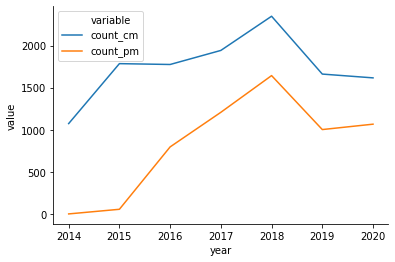

In [24]:
count_plot_data = pd.melt(
    pm_cm_results, id_vars=["year"], value_vars=["count_cm", "count_pm"]
)

sns.lineplot(data=count_plot_data, y="value", x="year", hue="variable")

sns.despine()

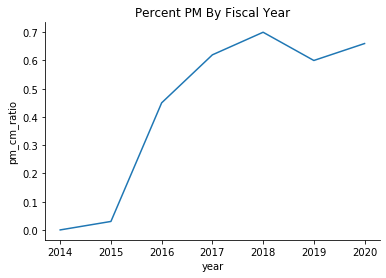

In [25]:
ax = sns.lineplot(data=pm_cm_results, y="pm_cm_ratio", x="year",)
ax.set(title="Percent PM By Fiscal Year")
sns.despine()

## KPI 3: % of Work Orders Completed On-Time (CM)
Here are the key facts needed to understand the agency's traditional method for computing this KPI:

- Only CM problem types are considered, so all PM work orders are dropped.
- The on-time benchmark is 24 days

In [29]:
wr_cm = wr_fy[~cond_pm]

print(f"We've gone from {len(wr_fy):,} rows to {len(wr_cm):,} rows.")

We've gone from 85,869 rows to 79,935 rows.


In [30]:
wr_cm_on_time = compute_is_on_time(wr_cm, 24)

In [31]:
pm_compliance = compute_kpi_table(wr_cm_on_time)
pm_compliance

,percent_on_time,total_pms
fiscal_year,,
2014,85.59,9453
2015,83.41,13488
2016,84.49,14761
2017,78.45,14261
2018,77.62,12485
2019,70.60,7174
2020,61.58,6770
2021,53.47,1543
